# **Project 1**, MIE1626 Winter 2022
**Data Science Methods and Quantitative Analysis - Home Credit Default Risk [90 Marks]**

**Deadline: February 11 at 21:00**

**Academic Integrity**

This project is individual: It is to be completed on your own. Do not share your code with others, or post any parts of your work online. You can only submit code that you have written yourself. If you use any online resource for developing parts of your code, acknowledge the source in a comment in your code. Students suspected of plagiarism on a project will be referred to the university for formal discipline according to the Code of Behaviour on Academic Matters.

Please fill out the following:


*   Name: Tianyu Shi
*   Student Number: 1007612264
*   UTorID: shitia26

## **Part 1: Getting started [20 Marks]**

* Load the data

Load the six csv files as pandas dataframes using a string 'path' for the location of files on your system (to be then updated by the marker for evaluation)

In [11]:
# Import necessary packages
import pandas as pd
import numpy as np
import math
from varclushi import VarClusHi
from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, f1_score, precision_score, recall_score, auc, roc_curve, confusion_matrix, classification_report

import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from xgboost import XGBClassifier, plot_importance

import sys

In [22]:
!pwd

/home/tianyu/code/project1


## load the dataset

In [12]:
### YOUR CODE HERE ###
#e.g. application_train

application_train = pd.read_csv('data/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('data/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('data/home-credit-default-risk/bureau_balance.csv')
POS_CASH_balance = pd.read_csv('data/home-credit-default-risk/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('data/home-credit-default-risk/credit_card_balance.csv')
installments_payments = pd.read_csv('data/home-credit-default-risk/installments_payments.csv')

print('shape of application_train',application_train.shape)
print('shape of bureau',bureau.shape)
print('shape of bureau_balance',bureau_balance.shape)
print('shape of POS_CASH_balance',POS_CASH_balance.shape)
print('shape of credit_card_balance',credit_card_balance.shape)
print('shape of installments_payments',installments_payments.shape)

shape of application_train (307511, 122)
shape of bureau (1716428, 17)
shape of bureau_balance (27299925, 3)
shape of POS_CASH_balance (10001358, 8)
shape of credit_card_balance (3840312, 23)
shape of installments_payments (13605401, 8)


In [13]:
bureau[0:10]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   
5      215354       5714467        Active      currency 1         -273   
6      215354       5714468        Active      currency 1          -43   
7      162297       5714469        Closed      currency 1        -1896   
8      162297       5714470        Closed      currency 1        -1146   
9      162297       5714471        Active      currency 1        -1146   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   
5                   0              27460.0                NaN   
6                   0                 79.0                NaN   
7                   0              -1684.0            -1710.0   
8                   0               -811.0             -840.0   
9                   0               -484.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0        91323.00   
1                     NaN                   0       225000.00   
2                     NaN                   0       464323.50   
3                     NaN                   0        90000.00   
4                 77674.5                   0      2700000.00   
5                     0.0                   0       180000.00   
6                     0.0                   0        42103.80   
7                 14985.0                   0        76878.45   
8                     0.0                   0       103007.70   
9                     0.0                   0         4500.00   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                 0.00                   NaN                     0.0   
1            171342.00                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   
5             71017.38             108982.62                     0.0   
6             42103.80                  0.00                     0.0   
7                 0.00                  0.00                     0.0   
8                 0.00                  0.00                     0.0   
9                 0.00                  0.00                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN  
5      Credit card                 -31          NaN  
6  Consumer credit                 -22          NaN  
7  Consumer credit               -1710          NaN  
8  Consumer credit                -840          NaN  
9      Credit card                -690          NaN

## 1.1 Data transformation and cleaning [15 Marks]

To conduct data cleaning, the first step is create and select relevant features. This includes the
following sub-steps:
1. Remove/disregard features that have a constant value.
2. Remove/disregard features that are irrelevant to credit risk or can’t be explained. This includes
time variables that are only related to the application and other variables that are not related to
the response.
3. Handle missing values.
4. Calculate the proportion of each outcome in dichotomous value to transform categorical variables
to continuous variables (explained below).
5. Create new variables.

See details in the project handout. 

#### bureau_balance data set

In [24]:
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [25]:
# calculate the proportion of 0 in the variable STATUS. (do I need to create any new variable?)
proportion_of_0= (bureau_balance['STATUS'].values == '0').sum()/(len(bureau_balance['STATUS']))
print('proportion_of_0 in the total dataset:',proportion_of_0)



proportion_of_0 in the total dataset: 0.2747079708094436


In [26]:
def status_to_numric_0(x):
    if x=='0':
        return 0
    else:
        return 1

In [27]:
# calculate the proportion of 0 in the variable STATUS. (do I need to create any new variable?)

## 1. there are some id that doesn't have 0, so it will end up nan, so we need to transform it numric value
## 2. we use sum / count to get non-zero proportion, then we can get zero proportion as 1- (non-zero proportion)
bureau_balance['0_or_not']=bureau_balance['STATUS'].apply(status_to_numric_0)
a=bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].count().rename('status_total').reset_index()
b=bureau_balance.groupby('SK_ID_BUREAU')['0_or_not'].sum().rename('status_sum').reset_index()
c=pd.merge(a,b,on='SK_ID_BUREAU')
c['0_prop']=1-c['status_sum']/c['status_total']
bureau_balance=pd.merge(c,bureau_balance,on='SK_ID_BUREAU')
bureau_balance


SK_ID_BUREAU  status_total  status_sum    0_prop  MONTHS_BALANCE  \
0              5001709            97          97  0.000000               0   
1              5001709            97          97  0.000000              -1   
2              5001709            97          97  0.000000              -2   
3              5001709            97          97  0.000000              -3   
4              5001709            97          97  0.000000              -4   
...                ...           ...         ...       ...             ...   
27299920       6842888            62          53  0.145161             -57   
27299921       6842888            62          53  0.145161             -58   
27299922       6842888            62          53  0.145161             -59   
27299923       6842888            62          53  0.145161             -60   
27299924       6842888            62          53  0.145161             -61   

         STATUS  0_or_not  
0             C         1  
1             C         1  
2             C         1  
3             C         1  
4             C         1  
...         ...       ...  
27299920      0         0  
27299921      1         1  
27299922      0         0  
27299923      0         0  
27299924      0         0  

[27299925 rows x 7 columns]

In [28]:
# print(bureau_balance.loc[bureau_balance['SK_ID_BUREAU']==5715448]) ## this is to check whether i am calculating correct

In [29]:
# Drop MONTHS_BALANCE as it’s irrelevant to the clients’ behaviour
bureau_balance_d=bureau_balance.drop('MONTHS_BALANCE',1)
bureau_balance_d=bureau_balance.drop(['status_sum','status_total','0_or_not'],1) ## we also want to remove these intermediate variables

bureau_balance_d

SK_ID_BUREAU    0_prop  MONTHS_BALANCE STATUS
0              5001709  0.000000               0      C
1              5001709  0.000000              -1      C
2              5001709  0.000000              -2      C
3              5001709  0.000000              -3      C
4              5001709  0.000000              -4      C
...                ...       ...             ...    ...
27299920       6842888  0.145161             -57      0
27299921       6842888  0.145161             -58      1
27299922       6842888  0.145161             -59      0
27299923       6842888  0.145161             -60      0
27299924       6842888  0.145161             -61      0

[27299925 rows x 4 columns]

In [30]:
# merge bureau_balance to bureau using the key SK_ID_BUREAU
bureau_combine=bureau.merge(bureau_balance_d,left_on='SK_ID_BUREAU',right_on='SK_ID_BUREAU')


In [31]:
bureau_combine.columns,bureau.columns

(Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
        'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
        'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
        'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
        'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
        'AMT_ANNUITY', '0_prop', 'MONTHS_BALANCE', 'STATUS'],
       dtype='object'),
 Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
        'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
        'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
        'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
        'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
        'AMT_ANNUITY'],
       dtype='object'))

In [32]:
bureau_combine


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0             380361       5715448        Active      currency 1         -820   
1             380361       5715448        Active      currency 1         -820   
2             380361       5715448        Active      currency 1         -820   
3             380361       5715448        Active      currency 1         -820   
4             380361       5715448        Active      currency 1         -820   
...              ...           ...           ...             ...          ...   
24179736      407724       5053758        Closed      currency 1        -2423   
24179737      407724       5053758        Closed      currency 1        -2423   
24179738      407724       5053758        Closed      currency 1        -2423   
24179739      407724       5053758        Closed      currency 1        -2423   
24179740      407724       5053758        Closed      currency 1        -2423   

          CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                          0              31069.0                NaN   
1                          0              31069.0                NaN   
2                          0              31069.0                NaN   
3                          0              31069.0                NaN   
4                          0              31069.0                NaN   
...                      ...                  ...                ...   
24179736                   0              -2150.0            -2175.0   
24179737                   0              -2150.0            -2175.0   
24179738                   0              -2150.0            -2175.0   
24179739                   0              -2150.0            -2175.0   
24179740                   0              -2150.0            -2175.0   

          AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                            NaN                   0         67500.0   
1                            NaN                   0         67500.0   
2                            NaN                   0         67500.0   
3                            NaN                   0         67500.0   
4                            NaN                   0         67500.0   
...                          ...                 ...             ...   
24179736                     NaN                   0         21883.5   
24179737                     NaN                   0         21883.5   
24179738                     NaN                   0         21883.5   
24179739                     NaN                   0         21883.5   
24179740                     NaN                   0         21883.5   

          AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                         0.0               67500.0                     0.0   
1                         0.0               67500.0                     0.0   
2                         0.0               67500.0                     0.0   
3                         0.0               67500.0                     0.0   
4                         0.0               67500.0                     0.0   
...                       ...                   ...                     ...   
24179736                  0.0                   NaN                     0.0   
24179737                  0.0                   NaN                     0.0   
24179738                  0.0                   NaN                     0.0   
24179739                  0.0                   NaN                     0.0   
24179740                  0.0                   NaN                     0.0   

              CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY    0_prop  \
0             Credit card                -183          0.0  0.296296   
1             Credit card                -183          0.0  0.296296   
2             Credit card                -183          0.0  0.296296   
3             Credit card                -183          0.0  0.296296  

#### bureau data set

In [33]:
bureau_combine.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', '0_prop', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [34]:
# For each SK_ID_CURR, calculate the proportion of Closed and Active of CREDIT_ACTIVE. （do we have to do anything with this calculation? here is the total percentage, after consulting the TA it seems this is redundant)
proportion_of_closed= (bureau_combine['CREDIT_ACTIVE'].values == 'Closed').sum()/(len(bureau_combine['CREDIT_ACTIVE']))
proportion_of_active= (bureau_combine['CREDIT_ACTIVE'].values == 'Active').sum()/(len(bureau_combine['CREDIT_ACTIVE']))

proportion_of_closed, proportion_of_active

(0.7655935189711089, 0.22935282888265843)

In [35]:
bureau_combine.CREDIT_ACTIVE.value_counts()

Closed      18511853
Active       5545692
Sold          122096
Bad debt         100
Name: CREDIT_ACTIVE, dtype: int64

In [36]:
def status_to_numric_actclos(x):
    if x=='Closed' or x=='Active':
        return 1
    else:
        return 0

In [37]:
bureau_combine['clos_active_or_not']=bureau_combine['CREDIT_ACTIVE'].apply(status_to_numric_actclos)
bureau_combine

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0             380361       5715448        Active      currency 1         -820   
1             380361       5715448        Active      currency 1         -820   
2             380361       5715448        Active      currency 1         -820   
3             380361       5715448        Active      currency 1         -820   
4             380361       5715448        Active      currency 1         -820   
...              ...           ...           ...             ...          ...   
24179736      407724       5053758        Closed      currency 1        -2423   
24179737      407724       5053758        Closed      currency 1        -2423   
24179738      407724       5053758        Closed      currency 1        -2423   
24179739      407724       5053758        Closed      currency 1        -2423   
24179740      407724       5053758        Closed      currency 1        -2423   

          CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                          0              31069.0                NaN   
1                          0              31069.0                NaN   
2                          0              31069.0                NaN   
3                          0              31069.0                NaN   
4                          0              31069.0                NaN   
...                      ...                  ...                ...   
24179736                   0              -2150.0            -2175.0   
24179737                   0              -2150.0            -2175.0   
24179738                   0              -2150.0            -2175.0   
24179739                   0              -2150.0            -2175.0   
24179740                   0              -2150.0            -2175.0   

          AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  \
0                            NaN                   0  ...   
1                            NaN                   0  ...   
2                            NaN                   0  ...   
3                            NaN                   0  ...   
4                            NaN                   0  ...   
...                          ...                 ...  ...   
24179736                     NaN                   0  ...   
24179737                     NaN                   0  ...   
24179738                     NaN                   0  ...   
24179739                     NaN                   0  ...   
24179740                     NaN                   0  ...   

          AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                         0.0               67500.0                     0.0   
1                         0.0               67500.0                     0.0   
2                         0.0               67500.0                     0.0   
3                         0.0               67500.0                     0.0   
4                         0.0               67500.0                     0.0   
...                       ...                   ...                     ...   
24179736                  0.0                   NaN                     0.0   
24179737                  0.0                   NaN                     0.0   
24179738                  0.0                   NaN                     0.0   
24179739                  0.0                   NaN                     0.0   
24179740                  0.0                   NaN                     0.0   

              CREDIT_TYPE DAYS_CREDIT_UPDATE  AMT_ANNUITY    0_prop  \
0             Credit card               -183          0.0  0.296296   
1             Credit card               -183          0.0  0.296296   
2             Credit card               -183          0.0  0.296296   
3             Credit card               -183          0.0  0.296296   
4             Credit card               -183          0.0  0.296296   
...                   ...                ...          ...       

In [38]:
a=bureau_combine.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].count().rename('status_total').reset_index()
b=bureau_combine.groupby('SK_ID_CURR')['clos_active_or_not'].sum().rename('status_sum').reset_index()
c=pd.merge(a,b,on='SK_ID_CURR')
c['clos_active_prop']=c['status_sum']/c['status_total']
bureau_combine=pd.merge(c,bureau_combine,on='SK_ID_CURR')

In [39]:
bureau_combine

SK_ID_CURR  status_total  status_sum  clos_active_prop  \
0             100001           172         172               1.0   
1             100001           172         172               1.0   
2             100001           172         172               1.0   
3             100001           172         172               1.0   
4             100001           172         172               1.0   
...              ...           ...         ...               ...   
24179736      456255           293         293               1.0   
24179737      456255           293         293               1.0   
24179738      456255           293         293               1.0   
24179739      456255           293         293               1.0   
24179740      456255           293         293               1.0   

          SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0              5896630        Closed      currency 1         -857   
1              5896630        Closed      currency 1         -857   
2              5896630        Closed      currency 1         -857   
3              5896630        Closed      currency 1         -857   
4              5896630        Closed      currency 1         -857   
...                ...           ...             ...          ...   
24179736       5126337        Closed      currency 1        -2337   
24179737       5126337        Closed      currency 1        -2337   
24179738       5126337        Closed      currency 1        -2337   
24179739       5126337        Closed      currency 1        -2337   
24179740       5126337        Closed      currency 1        -2337   

          CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  ...  AMT_CREDIT_SUM_DEBT  \
0                          0               -492.0  ...                  0.0   
1                          0               -492.0  ...                  0.0   
2                          0               -492.0  ...                  0.0   
3                          0               -492.0  ...                  0.0   
4                          0               -492.0  ...                  0.0   
...                      ...                  ...  ...                  ...   
24179736                   0              -1243.0  ...                  NaN   
24179737                   0              -1243.0  ...                  NaN   
24179738                   0              -1243.0  ...                  NaN   
24179739                   0              -1243.0  ...                  NaN   
24179740                   0              -1243.0  ...                  NaN   

          AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  \
0                          0.0                     0.0  Consumer credit   
1                          0.0                     0.0  Consumer credit   
2                          0.0                     0.0  Consumer credit   
3                          0.0                     0.0  Consumer credit   
4                          0.0                     0.0  Consumer credit   
...                        ...                     ...              ...   
24179736                   NaN                     0.0  Consumer credit   
24179737                   NaN                     0.0  Consumer credit   
24179738                   NaN                     0.0  Consumer credit   
24179739                   NaN                     0.0  Consumer credit   
24179740                   NaN                     0.0  Consumer credit   

          DAYS_CREDIT_UPDATE  AMT_ANNUITY    0_prop MONTHS_BALANCE  STATUS  \
0                       -155          0.0  0.103448              0       C   
1                       -155          0.0  0.103448             -1       C   
2                       -155          0.0  0.103448             -2       C   
3                       -155          0.0  0.103448             -3       C   
4                       -155          0.0  0.103448             -4       C   
...                      ...          ...     

In [40]:
# print(bureau_combine.loc[bureau_combine['SK_ID_CURR']==456255].CREDIT_ACTIVE) ## this is to check whether i am calculating correct
# print(bureau_combine.loc[bureau_combine['SK_ID_CURR']==456255].CREDIT_ACTIVE.value_counts) ## this is to check whether i am calculating correct

In [41]:
bureau_combine=bureau_combine.drop(['status_sum','status_total','clos_active_or_not'],1) ## we also want to remove these intermediate variables


In [42]:
# Remove CREDIT_CURRENCY as it’s constant.
bureau_combine = bureau_combine.drop('CREDIT_CURRENCY',1)
bureau_combine.columns

Index(['SK_ID_CURR', 'clos_active_prop', 'SK_ID_BUREAU', 'CREDIT_ACTIVE',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', '0_prop', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [43]:
# Remove DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT and
# DAYS_CREDIT_UPDATE as these are irrelevant variables.
bureau_combine = bureau_combine.drop(['DAYS_CREDIT','CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE'],1)
bureau_combine.columns

Index(['SK_ID_CURR', 'clos_active_prop', 'SK_ID_BUREAU', 'CREDIT_ACTIVE',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'CREDIT_TYPE', 'AMT_ANNUITY', '0_prop', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [44]:
bureau_combine

SK_ID_CURR  clos_active_prop  SK_ID_BUREAU CREDIT_ACTIVE  \
0             100001               1.0       5896630        Closed   
1             100001               1.0       5896630        Closed   
2             100001               1.0       5896630        Closed   
3             100001               1.0       5896630        Closed   
4             100001               1.0       5896630        Closed   
...              ...               ...           ...           ...   
24179736      456255               1.0       5126337        Closed   
24179737      456255               1.0       5126337        Closed   
24179738      456255               1.0       5126337        Closed   
24179739      456255               1.0       5126337        Closed   
24179740      456255               1.0       5126337        Closed   

          AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                            NaN                   0        112500.0   
1                            NaN                   0        112500.0   
2                            NaN                   0        112500.0   
3                            NaN                   0        112500.0   
4                            NaN                   0        112500.0   
...                          ...                 ...             ...   
24179736                 16618.5                   0        450000.0   
24179737                 16618.5                   0        450000.0   
24179738                 16618.5                   0        450000.0   
24179739                 16618.5                   0        450000.0   
24179740                 16618.5                   0        450000.0   

          AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                         0.0                   0.0                     0.0   
1                         0.0                   0.0                     0.0   
2                         0.0                   0.0                     0.0   
3                         0.0                   0.0                     0.0   
4                         0.0                   0.0                     0.0   
...                       ...                   ...                     ...   
24179736                  NaN                   NaN                     0.0   
24179737                  NaN                   NaN                     0.0   
24179738                  NaN                   NaN                     0.0   
24179739                  NaN                   NaN                     0.0   
24179740                  NaN                   NaN                     0.0   

              CREDIT_TYPE  AMT_ANNUITY    0_prop  MONTHS_BALANCE STATUS  
0         Consumer credit          0.0  0.103448               0      C  
1         Consumer credit          0.0  0.103448              -1      C  
2         Consumer credit          0.0  0.103448              -2      C  
3         Consumer credit          0.0  0.103448              -3      C  
4         Consumer credit          0.0  0.103448              -4      C  
...                   ...          ...       ...             ...    ...  
24179736  Consumer credit          0.0  0.028571             -72      C  
24179737  Consumer credit          0.0  0.028571             -73      C  
24179738  Consumer credit          0.0  0.028571             -74      C  
24179739  Consumer credit          0.0  0.028571             -75      0  
24179740  Consumer credit          0.0  0.028571             -76      X  

[24179741 rows x 15 columns]

In [45]:
# no longer need this key ?
# bureau_combine=bureau_combine.drop(['SK_ID_BUREAU'], axis = 1) 

In [46]:
bureau_combine.shape

(24179741, 15)

In [47]:
bureau_combine.CREDIT_TYPE.value_counts()

Consumer credit                                 18333667
Credit card                                      5019228
Car loan                                          446901
Mortgage                                          251213
Microloan                                          48856
Loan for business development                      42537
Another type of loan                               17271
Unknown type of loan                               13129
Loan for working capital replenishment              4902
Cash loan (non-earmarked)                           1445
Loan for the purchase of equipment                   291
Real estate loan                                     240
Loan for purchase of shares (margin lending)          35
Mobile operator loan                                  26
Name: CREDIT_TYPE, dtype: int64

In [48]:
def credit_to_numric(x):
    if x=='Consumer credit' or x=='Credit card':
        return 1
    else:
        return 0

bureau_combine['cons_cred_card_or_not']=bureau_combine['CREDIT_TYPE'].apply(credit_to_numric)
bureau_combine

SK_ID_CURR  clos_active_prop  SK_ID_BUREAU CREDIT_ACTIVE  \
0             100001               1.0       5896630        Closed   
1             100001               1.0       5896630        Closed   
2             100001               1.0       5896630        Closed   
3             100001               1.0       5896630        Closed   
4             100001               1.0       5896630        Closed   
...              ...               ...           ...           ...   
24179736      456255               1.0       5126337        Closed   
24179737      456255               1.0       5126337        Closed   
24179738      456255               1.0       5126337        Closed   
24179739      456255               1.0       5126337        Closed   
24179740      456255               1.0       5126337        Closed   

          AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                            NaN                   0        112500.0   
1                            NaN                   0        112500.0   
2                            NaN                   0        112500.0   
3                            NaN                   0        112500.0   
4                            NaN                   0        112500.0   
...                          ...                 ...             ...   
24179736                 16618.5                   0        450000.0   
24179737                 16618.5                   0        450000.0   
24179738                 16618.5                   0        450000.0   
24179739                 16618.5                   0        450000.0   
24179740                 16618.5                   0        450000.0   

          AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                         0.0                   0.0                     0.0   
1                         0.0                   0.0                     0.0   
2                         0.0                   0.0                     0.0   
3                         0.0                   0.0                     0.0   
4                         0.0                   0.0                     0.0   
...                       ...                   ...                     ...   
24179736                  NaN                   NaN                     0.0   
24179737                  NaN                   NaN                     0.0   
24179738                  NaN                   NaN                     0.0   
24179739                  NaN                   NaN                     0.0   
24179740                  NaN                   NaN                     0.0   

              CREDIT_TYPE  AMT_ANNUITY    0_prop  MONTHS_BALANCE STATUS  \
0         Consumer credit          0.0  0.103448               0      C   
1         Consumer credit          0.0  0.103448              -1      C   
2         Consumer credit          0.0  0.103448              -2      C   
3         Consumer credit          0.0  0.103448              -3      C   
4         Consumer credit          0.0  0.103448              -4      C   
...                   ...          ...       ...             ...    ...   
24179736  Consumer credit          0.0  0.028571             -72      C   
24179737  Consumer credit          0.0  0.028571             -73      C   
24179738  Consumer credit          0.0  0.028571             -74      C   
24179739  Consumer credit          0.0  0.028571             -75      0   
24179740  Consumer credit          0.0  0.028571             -76      X   

          cons_cred_card_or_not  
0                             1  
1                             1  
2                             1  
3                             1  
4                             1  
...                         ...  
24179736                      1  
24179737                      1  
24179738                      1  
24179739                      1  
24179740                      1  

[24179741 rows x 16 columns]

In [49]:
# For each SK_ID_CURR, calculate the proportion of Consumer credit and Credit card of CREDIT_TYPE.

a=bureau_combine.groupby('SK_ID_CURR')['CREDIT_TYPE'].count().rename('status_total').reset_index()
b=bureau_combine.groupby('SK_ID_CURR')['cons_cred_card_or_not'].sum().rename('status_sum').reset_index()
c=pd.merge(a,b,on='SK_ID_CURR')
c['cons_cred_card_prop']=c['status_sum']/c['status_total']
bureau_combine=pd.merge(c,bureau_combine,on='SK_ID_CURR')
bureau_combine=bureau_combine.drop(['status_sum','status_total','cons_cred_card_or_not'],1) ## we also want to remove these intermediate variables


In [50]:
print(bureau_combine.loc[bureau_combine['SK_ID_CURR']==456255].cons_cred_card_prop.value_counts()) ## this is to check whether i am calculating correct
print(bureau_combine.loc[bureau_combine['SK_ID_CURR']==456255].CREDIT_TYPE.value_counts()) ## this is to check whether i am calculating correct
# bureau_combine

1.0    293
Name: cons_cred_card_prop, dtype: int64
Consumer credit    247
Credit card         46
Name: CREDIT_TYPE, dtype: int64


In [51]:
# calculate the average for the numerical variable per SK_ID_CURR and use the calculated average
# to present the corresponding feature value for that SK_ID_CURR For example, the variable that
# you created based on the proportion of 0 in the variable STATUS is to be averaged for each unique
# SK_ID_CURR before being merged with application_train.
bureau_num = bureau_combine.groupby(by=['SK_ID_CURR']).mean().reset_index()                          # group the numeric features by SK_ID_CURR
print(bureau_num.shape, "- shape of numeric bureau features (incl index)")                          
bureau_cat = pd.get_dummies(bureau_combine.select_dtypes('object'))                                         # this got rid of the SK_ID_CURR column ...
bureau_cat['SK_ID_CURR'] = bureau_combine['SK_ID_CURR']                                                     # so we have to replace it
bureau_cat = bureau_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()                          # tried sum - didn't change anything
print(bureau_cat.shape, "- shape of categorical bureau features (incl index)")                      # should be 


(134542, 13) - shape of numeric bureau features (incl index)
(134542, 27) - shape of categorical bureau features (incl index)


In [52]:
bureau_cat

SK_ID_CURR  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  \
0           100001              0.186047                     0.0   
1           100002              0.181818                     0.0   
2           100005              0.380952                     0.0   
3           100010              0.500000                     0.0   
4           100013              0.000000                     0.0   
...            ...                   ...                     ...   
134537      456247              0.146875                     0.0   
134538      456250              0.620690                     0.0   
134539      456253              0.470085                     0.0   
134540      456254              0.000000                     0.0   
134541      456255              0.317406                     0.0   

        CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  \
0                   0.813953                 0.0   
1                   0.818182                 0.0   
2                   0.619048                 0.0   
3                   0.500000                 0.0   
4                   1.000000                 0.0   
...                      ...                 ...   
134537              0.853125                 0.0   
134538              0.379310                 0.0   
134539              0.529915                 0.0   
134540              1.000000                 0.0   
134541              0.682594                 0.0   

        CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan  \
0                                    0.0              0.000000   
1                                    0.0              0.000000   
2                                    0.0              0.000000   
3                                    0.0              0.000000   
4                                    0.0              0.526087   
...                                  ...                   ...   
134537                               0.0              0.000000   
134538                               0.0              0.000000   
134539                               0.0              0.000000   
134540                               0.0              0.000000   
134541                               0.0              0.000000   

        CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit  \
0                                         0.0                     1.000000   
1                                         0.0                     0.472727   
2                                         0.0                     0.380952   
3                                         0.0                     0.500000   
4                                         0.0                     0.473913   
...                                       ...                          ...   
134537                                    0.0                     0.887500   
134538                                    0.0                     0.678161   
134539                                    0.0                     0.735043   
134540                                    0.0                     1.000000   
134541                                    0.0                     0.843003   

        CREDIT_TYPE_Credit card  ...  CREDIT_TYPE_Real estate loan  \
0                      0.000000  ...                           0.0   
1                      0.527273  ...                           0.0   
2                      0.619048  ...                           0.0   
3                      0.000000  ...                           0.0   
4                      0.000000  ...                           0.0   
...                         ...  ...                           ...   
134537                 0.037500  ...                           0.0   
134538                 0.321839  ...                           0.0   
134539                 0.264957  ...                           0.0   
134540                 0.000000  ...                           0.0   
134541                 0.156997  ...                           0.0

In [53]:
bureau_num

SK_ID_CURR  cons_cred_card_prop  clos_active_prop  SK_ID_BUREAU  \
0           100001             1.000000               1.0  5.896632e+06   
1           100002             1.000000               1.0  6.152350e+06   
2           100005             1.000000               1.0  6.735201e+06   
3           100010             0.500000               1.0  5.576631e+06   
4           100013             0.473913               1.0  5.922081e+06   
...            ...                  ...               ...           ...   
134537      456247             0.925000               1.0  6.353728e+06   
134538      456250             1.000000               1.0  6.817237e+06   
134539      456253             1.000000               1.0  5.864376e+06   
134540      456254             1.000000               1.0  6.669849e+06   
134541      456255             1.000000               1.0  5.126332e+06   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                          NaN            0.000000   161516.250000   
1                  1312.010357            0.000000   111388.838727   
2                     0.000000            0.000000   175903.714286   
3                          NaN            0.000000   495000.000000   
4                 19305.000000            0.000000   532530.923478   
...                        ...                 ...             ...   
134537             4612.367773            0.031250   367670.334375   
134538                0.000000            0.000000   971625.227586   
134539                     NaN            0.000000   914615.384615   
134540                     NaN            0.000000    45000.000000   
134541            13629.984961            0.112628   342536.498294   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0              23893.770349              0.000000                     0.0   
1              70223.142857           3198.856500                     0.0   
2             132923.785714              0.000000                     0.0   
3             174003.750000              0.000000                     0.0   
4                  0.000000                   NaN                     0.0   
...                     ...                   ...                     ...   
134537        417788.571429              0.000000                     0.0   
134538        676051.789655          18753.043448                     0.0   
134539        378608.923077              0.000000                     0.0   
134540             0.000000                   NaN                     0.0   
134541        179242.109531              0.000000                     0.0   

          AMT_ANNUITY    0_prop  MONTHS_BALANCE  
0         1236.244186  0.180233      -16.279070  
1            0.000000  0.409091      -24.554545  
2          608.785714  0.666667       -4.333333  
3                 NaN  0.277778      -46.000000  
4            0.000000  0.343478      -29.373913  
...               ...       ...             ...  
134537    4837.617904  0.206250      -27.281250  
134538  170124.655862  0.137931      -14.149425  
134539   58369.500000  0.401709      -14.282051  
134540       0.000000  0.216216      -18.000000  
134541    1059.695565  0.215017      -26.392491  

[134542 rows x 13 columns]

In [54]:
bureau_combine

SK_ID_CURR  cons_cred_card_prop  clos_active_prop  SK_ID_BUREAU  \
0             100001                  1.0               1.0       5896630   
1             100001                  1.0               1.0       5896630   
2             100001                  1.0               1.0       5896630   
3             100001                  1.0               1.0       5896630   
4             100001                  1.0               1.0       5896630   
...              ...                  ...               ...           ...   
24179736      456255                  1.0               1.0       5126337   
24179737      456255                  1.0               1.0       5126337   
24179738      456255                  1.0               1.0       5126337   
24179739      456255                  1.0               1.0       5126337   
24179740      456255                  1.0               1.0       5126337   

         CREDIT_ACTIVE  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0               Closed                     NaN                   0   
1               Closed                     NaN                   0   
2               Closed                     NaN                   0   
3               Closed                     NaN                   0   
4               Closed                     NaN                   0   
...                ...                     ...                 ...   
24179736        Closed                 16618.5                   0   
24179737        Closed                 16618.5                   0   
24179738        Closed                 16618.5                   0   
24179739        Closed                 16618.5                   0   
24179740        Closed                 16618.5                   0   

          AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0               112500.0                  0.0                   0.0   
1               112500.0                  0.0                   0.0   
2               112500.0                  0.0                   0.0   
3               112500.0                  0.0                   0.0   
4               112500.0                  0.0                   0.0   
...                  ...                  ...                   ...   
24179736        450000.0                  NaN                   NaN   
24179737        450000.0                  NaN                   NaN   
24179738        450000.0                  NaN                   NaN   
24179739        450000.0                  NaN                   NaN   
24179740        450000.0                  NaN                   NaN   

          AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  AMT_ANNUITY    0_prop  \
0                            0.0  Consumer credit          0.0  0.103448   
1                            0.0  Consumer credit          0.0  0.103448   
2                            0.0  Consumer credit          0.0  0.103448   
3                            0.0  Consumer credit          0.0  0.103448   
4                            0.0  Consumer credit          0.0  0.103448   
...                          ...              ...          ...       ...   
24179736                     0.0  Consumer credit          0.0  0.028571   
24179737                     0.0  Consumer credit          0.0  0.028571   
24179738                     0.0  Consumer credit          0.0  0.028571   
24179739                     0.0  Consumer credit          0.0  0.028571   
24179740                     0.0  Consumer credit          0.0  0.028571   

          MONTHS_BALANCE STATUS  
0                      0      C  
1                     -1      C  
2                     -2      C  
3                     -3      C  
4                     -4      C  
...                  ...    ...  
24179736             -72      C  
24179737             -73      C  
24179738             -74      C  
24179739             -75      0  
24179740             -76      X  

[24179741 rows x 16 columns]

In [55]:
bureau_combine_d=bureau_combine.drop(['CREDIT_ACTIVE','CREDIT_TYPE','STATUS'],1) ## we also want to remove these intermediate variables
bureau_combine_d=bureau_combine_d.groupby(by=['SK_ID_CURR']).mean().reset_index()         # group the numeric features by SK_ID_CURR by average
bureau_combine_d ## do we need to fill in nan??

SK_ID_CURR  cons_cred_card_prop  clos_active_prop  SK_ID_BUREAU  \
0           100001             1.000000               1.0  5.896632e+06   
1           100002             1.000000               1.0  6.152350e+06   
2           100005             1.000000               1.0  6.735201e+06   
3           100010             0.500000               1.0  5.576631e+06   
4           100013             0.473913               1.0  5.922081e+06   
...            ...                  ...               ...           ...   
134537      456247             0.925000               1.0  6.353728e+06   
134538      456250             1.000000               1.0  6.817237e+06   
134539      456253             1.000000               1.0  5.864376e+06   
134540      456254             1.000000               1.0  6.669849e+06   
134541      456255             1.000000               1.0  5.126332e+06   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                          NaN            0.000000   161516.250000   
1                  1312.010357            0.000000   111388.838727   
2                     0.000000            0.000000   175903.714286   
3                          NaN            0.000000   495000.000000   
4                 19305.000000            0.000000   532530.923478   
...                        ...                 ...             ...   
134537             4612.367773            0.031250   367670.334375   
134538                0.000000            0.000000   971625.227586   
134539                     NaN            0.000000   914615.384615   
134540                     NaN            0.000000    45000.000000   
134541            13629.984961            0.112628   342536.498294   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0              23893.770349              0.000000                     0.0   
1              70223.142857           3198.856500                     0.0   
2             132923.785714              0.000000                     0.0   
3             174003.750000              0.000000                     0.0   
4                  0.000000                   NaN                     0.0   
...                     ...                   ...                     ...   
134537        417788.571429              0.000000                     0.0   
134538        676051.789655          18753.043448                     0.0   
134539        378608.923077              0.000000                     0.0   
134540             0.000000                   NaN                     0.0   
134541        179242.109531              0.000000                     0.0   

          AMT_ANNUITY    0_prop  MONTHS_BALANCE  
0         1236.244186  0.180233      -16.279070  
1            0.000000  0.409091      -24.554545  
2          608.785714  0.666667       -4.333333  
3                 NaN  0.277778      -46.000000  
4            0.000000  0.343478      -29.373913  
...               ...       ...             ...  
134537    4837.617904  0.206250      -27.281250  
134538  170124.655862  0.137931      -14.149425  
134539   58369.500000  0.401709      -14.282051  
134540       0.000000  0.216216      -18.000000  
134541    1059.695565  0.215017      -26.392491  

[134542 rows x 13 columns]

In [56]:
len(bureau_combine_d.SK_ID_CURR.unique())

134542

In [57]:
### YOUR CODE HERE ###

#### installment_payment dataset

In [58]:
installments_payments

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
1               1716.525     1716.525  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
...                  ...          ...  
13605396          67.500          NaN  
13605397          67.500          NaN  
13605398       43737.435          NaN  
13605399          67.500          NaN  
13605400       11504.250          NaN  

[13605401 rows x 8 columns]

In [59]:
# Combine AMT_INSTALMENT and AMT_PAYMENT into one variable indicating whether the client has
# paid out the installment on time. One new dummy variable should be created based on the following criterion: if AMT_PAYMENT ≥ AMT_INSTALMENT, then the dummy equals 1, otherwise it equals 0.


paydiff= installments_payments['AMT_PAYMENT']-installments_payments['AMT_INSTALMENT']
installments_payments['paid_on_time'] = paydiff.apply(lambda x: 1 if x>=0 else 0)
# plt.plot(a)



In [60]:
installments_payments['paid_on_time']

print('percent of paid on time', installments_payments['paid_on_time'].sum()/len(installments_payments['paid_on_time']))
print('maximum paydiff',paydiff.max(skipna = True))

## drop  AMT_INSTALMENT and AMT_PAYMENT because we already have that dummy variable now
installments_payments_new = installments_payments.drop(['AMT_PAYMENT','AMT_INSTALMENT'],1)


percent of paid on time 0.9045674581734121
maximum paydiff 2630908.935


In [61]:
# Then, calculate the maximum of that dummy variable for each SK_ID_CURR.
maxima = installments_payments_new.groupby('SK_ID_CURR')['paid_on_time'].max()

installments_payments_new['max_paid_on_time']=installments_payments_new['SK_ID_CURR'].map(maxima)
installments_payments_new

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          paid_on_time  max_paid_on_time  
0                    1                 1  
1                    1                 1  
2                    1                 1  
3                    1                 1  
4                    0                 1  
...                ...               ...  
13605396             0                 1  
13605397             0                 1  
13605398             0                 1  
13605399             0                 1  
13605400             0                 1  

[13605401 rows x 8 columns]

In [62]:
installments_payments_u=installments_payments_new.groupby(by=['SK_ID_CURR']).mean().reset_index()        
len(installments_payments_u.SK_ID_CURR.unique()) ## there would be some duplicate skidcurr  

339587

In [63]:
len(installments_payments_new.SK_ID_CURR.unique()) ## there would be some duplicate skidcurr

339587

#### credit_card_balance dataset

In [64]:
credit_card_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
0                           877.5                 1700.325  ...   
1                             0.0                 2250.000  ...   
2                             0.0                 2250.000  ...   
3                             0.0                11795.760  ...   
4                         11547.0                22924.890  ...   
...                           ...                      ...  ...   
3840307                       NaN                    0.000  ...   
3840308                       0.0                    0.000  ...   
3840309                       0.0                 2250.000  ...   
3840310                       NaN                    0.000  ...   
3840311                       0.0                    0.000  ...   

         AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
0                0.000                 0.000                       0.0   
1            64875.555             64875.555                       1.0   
2            31460.085             31460.085                       0.0   
3           233048.970            233048.970                       1.0   
4           453919.455            453919.455                       0.0   
...                ...                   ...                       ...   
3840307          0.000                 0.000                       NaN   
3840308          0.000                 0.000                       0.0   
3840309     273093.975            273093.975                       2.0   
3840310          0.000                 0.000                       NaN   
3840311          0.000                 0.000                       0.0   

         CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0      

In [65]:
# For the variables AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_DRAWINGS_OTHER_CURRENT,
# AMT_DRAWINGS_POS_CURRENT, AMT_RECIVABLE, and AMT_TOTAL_RECEIVABLE replace all NA with 0 
cols= ['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE']
credit_card_balance[cols]=credit_card_balance[cols].fillna(0)
credit_card_balance 

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       0.0   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       0.0   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         0.0   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         0.0   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
0                           877.5                 1700.325  ...   
1                             0.0                 2250.000  ...   
2                             0.0                 2250.000  ...   
3                             0.0                11795.760  ...   
4                         11547.0                22924.890  ...   
...                           ...                      ...  ...   
3840307                       0.0                    0.000  ...   
3840308                       0.0                    0.000  ...   
3840309                       0.0                 2250.000  ...   
3840310                       0.0                    0.000  ...   
3840311                       0.0                    0.000  ...   

         AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
0                0.000                 0.000                       0.0   
1            64875.555             64875.555                       1.0   
2            31460.085             31460.085                       0.0   
3           233048.970            233048.970                       1.0   
4           453919.455            453919.455                       0.0   
...                ...                   ...                       ...   
3840307          0.000                 0.000                       NaN   
3840308          0.000                 0.000                       0.0   
3840309     273093.975            273093.975                       2.0   
3840310          0.000                 0.000                       NaN   
3840311          0.000                 0.000                       0.0   

         CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0      

In [66]:
len(credit_card_balance.SK_ID_CURR.unique())

103558

In [67]:
# then compute average for each SK_ID_CURR.
ccb_num = credit_card_balance.groupby(by=['SK_ID_CURR']).mean().reset_index()            # group the numeric features by SK_ID_CURR
ccb_num

SK_ID_CURR  SK_ID_PREV  MONTHS_BALANCE    AMT_BALANCE  \
0           100006   1489396.0            -3.5       0.000000   
1           100011   1843384.0           -38.5   54482.111149   
2           100013   2038692.0           -48.5   18159.919219   
3           100021   2594025.0           -10.0       0.000000   
4           100023   1499902.0            -7.5       0.000000   
...            ...         ...             ...            ...   
103553      456244   2181926.0           -21.0  131834.730732   
103554      456246   1079732.0            -5.5   13136.731875   
103555      456247   1595171.0           -49.0   23216.396211   
103556      456248   2743495.0           -13.0       0.000000   
103557      456250   1794451.0            -6.5  173589.326250   

        AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                 270000.000000                  0.000000   
1                 164189.189189               2432.432432   
2                 131718.750000               5953.125000   
3                 675000.000000                  0.000000   
4                 135000.000000                  0.000000   
...                         ...                       ...   
103553            296341.463415              24475.609756   
103554            135000.000000                  0.000000   
103555            144000.000000               2136.315789   
103556            900000.000000                  0.000000   
103557            178875.000000              15000.000000   

        AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                   0.000000                         0.0   
1                2432.432432                         0.0   
2                5953.125000                         0.0   
3                   0.000000                         0.0   
4                   0.000000                         0.0   
...                      ...                         ...   
103553          26842.388049                         0.0   
103554          15199.256250                         0.0   
103555           2149.506474                         0.0   
103556              0.000000                         0.0   
103557          15000.000000                         0.0   

        AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
0                       0.000000                 0.000000  ...   
1                       0.000000              3956.221849  ...   
2                       0.000000              1454.539551  ...   
3                       0.000000                 0.000000  ...   
4                       0.000000                 0.000000  ...   
...                          ...                      ...  ...   
103553               2363.015854              6514.200000  ...   
103554              15199.256250              1439.150625  ...   
103555                 13.190684              1414.704789  ...   
103556                  0.000000                 0.000000  ...   
103557                  0.000000              7540.080000  ...   

        AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                       0.000000       0.000000              0.000000   
1                   52402.088919   54433.179122          54433.179122   
2                   17255.559844   18101.079844          18101.079844   
3                       0.000000       0.000000              0.000000   
4                       0.000000       0.000000              0.000000   
...                          ...            ...                   ...   
103553             127608.373537  130767.060732         130767.060732   
103554              12883.016250   12897.894375          12897.894375   
103555              22100.653895   23128.243105          23128.243105   
103556                  0.000000       0.000000              0.000000   
103557             168446.591250  172237.526250         172237.526250   

        CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
0                            NaN             

In [68]:
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [69]:
 ### how to deal with this categorical?
ccb_cat = pd.get_dummies(credit_card_balance.select_dtypes('object'))                  # this got rid of the SK_ID_CURR column ...
ccb_cat

NAME_CONTRACT_STATUS_Active  NAME_CONTRACT_STATUS_Approved  \
0                                  1                              0   
1                                  1                              0   
2                                  1                              0   
3                                  1                              0   
4                                  1                              0   
...                              ...                            ...   
3840307                            1                              0   
3840308                            1                              0   
3840309                            1                              0   
3840310                            1                              0   
3840311                            0                              0   

         NAME_CONTRACT_STATUS_Completed  NAME_CONTRACT_STATUS_Demand  \
0                                     0                            0   
1                                     0                            0   
2                                     0                            0   
3                                     0                            0   
4                                     0                            0   
...                                 ...                          ...   
3840307                               0                            0   
3840308                               0                            0   
3840309                               0                            0   
3840310                               0                            0   
3840311                               1                            0   

         NAME_CONTRACT_STATUS_Refused  NAME_CONTRACT_STATUS_Sent proposal  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   
...                               ...                                 ...   
3840307                             0                                   0   
3840308                             0                                   0   
3840309                             0                                   0   
3840310                             0                                   0   
3840311                             0                                   0   

         NAME_CONTRACT_STATUS_Signed  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  
...                              ...  
3840307                            0  
3840308                            0  
3840309                            0  
3840310                            0  
3840311                            0  

[3840312 rows x 7 columns]

In [70]:
ccb_cat['SK_ID_CURR'] = credit_card_balance['SK_ID_CURR']                                # so we have to replace it
ccb_cat = ccb_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()      # could try sum as wel
ccb_cat

SK_ID_CURR  NAME_CONTRACT_STATUS_Active  \
0           100006                     1.000000   
1           100011                     1.000000   
2           100013                     1.000000   
3           100021                     0.411765   
4           100023                     1.000000   
...            ...                          ...   
103553      456244                     0.878049   
103554      456246                     1.000000   
103555      456247                     1.000000   
103556      456248                     1.000000   
103557      456250                     1.000000   

        NAME_CONTRACT_STATUS_Approved  NAME_CONTRACT_STATUS_Completed  \
0                                 0.0                        0.000000   
1                                 0.0                        0.000000   
2                                 0.0                        0.000000   
3                                 0.0                        0.588235   
4                                 0.0                        0.000000   
...                               ...                             ...   
103553                            0.0                        0.121951   
103554                            0.0                        0.000000   
103555                            0.0                        0.000000   
103556                            0.0                        0.000000   
103557                            0.0                        0.000000   

        NAME_CONTRACT_STATUS_Demand  NAME_CONTRACT_STATUS_Refused  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
103553                          0.0                           0.0   
103554                          0.0                           0.0   
103555                          0.0                           0.0   
103556                          0.0                           0.0   
103557                          0.0                           0.0   

        NAME_CONTRACT_STATUS_Sent proposal  NAME_CONTRACT_STATUS_Signed  
0                                      0.0                          0.0  
1                                      0.0                          0.0  
2                                      0.0                          0.0  
3                                      0.0                          0.0  
4                                      0.0                          0.0  
...                                    ...                          ...  
103553                                 0.0                          0.0  
103554                                 0.0                          0.0  
103555                                 0.0                          0.0  
103556                                 0.0                          0.0  
103557                                 0.0                          0.0  

[103558 rows x 8 columns]

In [71]:
credit_card_balance_u=pd.merge(ccb_num,ccb_cat,on='SK_ID_CURR')

In [72]:
len(credit_card_balance_u)==len(credit_card_balance_u.SK_ID_CURR.unique())

True

#### POS_CASH_balance

In [73]:
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [74]:
# Pick variable SK_DPD, replace NA with 0 if any, and make it into a dummy variable based on the
# following criterion: If the original value is 0 then keep it as 0, else replace original value with 1.
POS_CASH_balance['SK_DPD']=POS_CASH_balance['SK_DPD'].fillna(0)
POS_CASH_balance['SK_DPD'] = POS_CASH_balance['SK_DPD'].apply(lambda x: 1 if x>0 else 0)


In [75]:
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active       1           0  
10001354                    0.0               Active       1           0  
10001355                    0.0               Active       1           0  
10001356                    0.0               Active       1           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [76]:
# Then, take the maximum of the newly created dummy variable for each SK_ID_CURR.
maxima = POS_CASH_balance.groupby('SK_ID_CURR')['SK_DPD'].max()

POS_CASH_balance['max_SK_DPD']=POS_CASH_balance['SK_ID_CURR'].map(maxima)
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  \
0                          45.0               Active       0           0   
1                          35.0               Active       0           0   
2                           9.0               Active       0           0   
3                          42.0               Active       0           0   
4                          35.0               Active       0           0   
...                         ...                  ...     ...         ...   
10001353                    0.0               Active       1           0   
10001354                    0.0               Active       1           0   
10001355                    0.0               Active       1           0   
10001356                    0.0               Active       1           0   
10001357                    0.0            Completed       0           0   

          max_SK_DPD  
0                  0  
1                  0  
2                  1  
3                  0  
4                  0  
...              ...  
10001353           1  
10001354           1  
10001355           1  
10001356           1  
10001357           0  

[10001358 rows x 9 columns]

In [77]:
# Replace NA with 0 for CNT_INSTALMENT_FUTURE, and take its average for each SK_ID_CURR.
POS_CASH_balance['CNT_INSTALMENT_FUTURE']=POS_CASH_balance['CNT_INSTALMENT_FUTURE'].fillna(0)
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  \
0                          45.0               Active       0           0   
1                          35.0               Active       0           0   
2                           9.0               Active       0           0   
3                          42.0               Active       0           0   
4                          35.0               Active       0           0   
...                         ...                  ...     ...         ...   
10001353                    0.0               Active       1           0   
10001354                    0.0               Active       1           0   
10001355                    0.0               Active       1           0   
10001356                    0.0               Active       1           0   
10001357                    0.0            Completed       0           0   

          max_SK_DPD  
0                  0  
1                  0  
2                  1  
3                  0  
4                  0  
...              ...  
10001353           1  
10001354           1  
10001355           1  
10001356           1  
10001357           0  

[10001358 rows x 9 columns]

In [78]:
POS_CASH_balance_u=POS_CASH_balance.groupby(by=['SK_ID_CURR']).mean().reset_index()  

In [79]:
len(POS_CASH_balance_u)==len(POS_CASH_balance.SK_ID_CURR.unique())

True

#### result report

 Report the shape of the combined dataset.

In [80]:
application_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [81]:
### YOUR ANSWER HERE ###
## combine these dataset : bureau_combine_d,installments_payments_u,POS_CASH_balance_u,credit_card_balance_u,
application_train_m1=pd.merge(application_train,bureau_combine_d,on='SK_ID_CURR')
application_train_m2=pd.merge(application_train_m1,installments_payments_u,on='SK_ID_CURR')
application_train_m3=pd.merge(application_train_m2,POS_CASH_balance_u,on='SK_ID_CURR')
application_train_m=pd.merge(application_train_m3,credit_card_balance_u,on='SK_ID_CURR')

Note that this merge method is based on my previous understanding of the instruction to merge all the four given csv files into the training dataset

In [82]:
print('the shape of the combined dataset is:',application_train_m.shape)
application_train_m.to_csv('/home/tianyu/code/project1/data/home-credit-default-risk/application_m.csv')
application_train_m 

the shape of the combined dataset is: (28981, 176)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0          100043       0         Cash loans           F            N   
1          100048       0         Cash loans           F            N   
2          100050       0         Cash loans           F            N   
3          100059       0         Cash loans           M            Y   
4          100100       0         Cash loans           M            Y   
...           ...     ...                ...         ...          ...   
28976      456233       1         Cash loans           F            N   
28977      456235       0         Cash loans           M            Y   
28978      456242       0         Cash loans           M            Y   
28979      456244       0         Cash loans           F            N   
28980      456247       0         Cash loans           F            N   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                   Y             2          198000.0    641173.5   
1                   Y             0          202500.0    604152.0   
2                   Y             0          108000.0    746280.0   
3                   Y             1          540000.0    675000.0   
4                   Y             2          202500.0    796396.5   
...               ...           ...               ...         ...   
28976               Y             0          225000.0    521280.0   
28977               Y             2           90000.0   1078200.0   
28978               Y             0          198000.0   1312110.0   
28979               Y             0          261000.0   1303812.0   
28980               Y             0          112500.0    345510.0   

       AMT_ANNUITY_x  ...  CNT_INSTALMENT_MATURE_CUM  SK_DPD_y SK_DPD_DEF_y  \
0            23157.0  ...                  13.870968  0.000000     0.000000   
1            29196.0  ...                  12.344828  0.000000     0.000000   
2            42970.5  ...                   0.000000  0.000000     0.000000   
3            34596.0  ...                   0.000000  0.000000     0.000000   
4            38443.5  ...                  38.774194  0.127660     0.127660   
...              ...  ...                        ...       ...          ...   
28976        23089.5  ...                   2.800000  0.000000     0.000000   
28977        31522.5  ...                   0.000000  0.000000     0.000000   
28978        52168.5  ...                   3.500000  0.000000     0.000000   
28979        35982.0  ...                  13.600000  0.000000     0.000000   
28980        17770.5  ...                  26.494737  0.031579     0.021053   

      NAME_CONTRACT_STATUS_Active NAME_CONTRACT_STATUS_Approved  \
0                        1.000000                           0.0   
1                        1.000000                           0.0   
2                        1.000000                           0.0   
3                        0.600000                           0.0   
4                        0.968085                           0.0   
...                           ...                           ...   
28976                    1.000000                           0.0   
28977                    1.000000                           0.0   
28978                    1.000000                           0.0   
28979                    0.878049                           0.0   
28980                    1.000000                           0.0   

      NAME_CONTRACT_STATUS_Completed  NAME_CONTRACT_STATUS_Demand  \
0                           0.000000                          0.0   
1                           0.000000                          0.0   
2                           0.000000                          0.0   
3                           0.400000                          0.0   
4                           0.000000                          0.0   
...                              ...                          ...   
28976                       0.000000                          0.

Note that this merge method is only merge the new variables picked or transformed from the four csv files


In [83]:
### YOUR ANSWER HERE ###
## combine these dataset : bureau_combine_d,installments_payments_u,POS_CASH_balance_u,credit_card_balance_u,
bureau_combine_d_m = pd.DataFrame(bureau_combine_d, columns=['0_prop','clos_active_prop','cons_cred_card_prop','SK_ID_CURR'])
installments_payments_u_m = pd.DataFrame(installments_payments_u, columns=['max_paid_on_time','SK_ID_CURR'])
POS_CASH_balance_u_m = pd.DataFrame(POS_CASH_balance_u, columns=['max_SK_DPD','CNT_INSTALMENT_FUTURE','SK_ID_CURR'])
credit_card_balance_u_m = pd.DataFrame(credit_card_balance_u, columns=['SK_ID_CURR','AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE'])


application_train_m1=pd.merge(application_train,bureau_combine_d_m,on='SK_ID_CURR')
application_train_m2=pd.merge(application_train_m1,installments_payments_u_m,on='SK_ID_CURR')
application_train_m3=pd.merge(application_train_m2,POS_CASH_balance_u_m,on='SK_ID_CURR')
application_train_m_new=pd.merge(application_train_m3,credit_card_balance_u_m,on='SK_ID_CURR')

In [84]:
print('the shape of the combined dataset is:',application_train_m_new.shape)

application_train_m_new


the shape of the combined dataset is: (28981, 134)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0          100043       0         Cash loans           F            N   
1          100048       0         Cash loans           F            N   
2          100050       0         Cash loans           F            N   
3          100059       0         Cash loans           M            Y   
4          100100       0         Cash loans           M            Y   
...           ...     ...                ...         ...          ...   
28976      456233       1         Cash loans           F            N   
28977      456235       0         Cash loans           M            Y   
28978      456242       0         Cash loans           M            Y   
28979      456244       0         Cash loans           F            N   
28980      456247       0         Cash loans           F            N   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                   Y             2          198000.0    641173.5   
1                   Y             0          202500.0    604152.0   
2                   Y             0          108000.0    746280.0   
3                   Y             1          540000.0    675000.0   
4                   Y             2          202500.0    796396.5   
...               ...           ...               ...         ...   
28976               Y             0          225000.0    521280.0   
28977               Y             2           90000.0   1078200.0   
28978               Y             0          198000.0   1312110.0   
28979               Y             0          261000.0   1303812.0   
28980               Y             0          112500.0    345510.0   

       AMT_ANNUITY  ...  cons_cred_card_prop max_paid_on_time max_SK_DPD  \
0          23157.0  ...             1.000000              1.0        0.0   
1          29196.0  ...             0.000000              1.0        0.0   
2          42970.5  ...             1.000000              1.0        0.0   
3          34596.0  ...             0.876923              1.0        0.0   
4          38443.5  ...             0.666667              1.0        0.0   
...            ...  ...                  ...              ...        ...   
28976      23089.5  ...             1.000000              1.0        0.0   
28977      31522.5  ...             0.626016              1.0        0.0   
28978      52168.5  ...             1.000000              1.0        0.0   
28979      35982.0  ...             1.000000              1.0        1.0   
28980      17770.5  ...             0.925000              1.0        0.0   

      CNT_INSTALMENT_FUTURE AMT_DRAWINGS_ATM_CURRENT AMT_DRAWINGS_CURRENT  \
0                 34.324324              2045.454545         14904.972273   
1                 13.437500               870.967742         16009.548387   
2                 16.500000                 0.000000             0.000000   
3                 19.458333                 0.000000             0.000000   
4                 10.209677              4538.297872          5164.515957   
...                     ...                      ...                  ...   
28976              7.500000              2475.000000         16861.896000   
28977             10.514286                 0.000000             0.000000   
28978              5.718750             23062.500000         39849.783750   
28979             11.575000             24475.609756         26842.388049   
28980              4.518519              2136.315789          2149.506474   

       AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  AMT_RECIVABLE  \
0                        0.000000              12859.517727  208397.449091   
1                        0.000000              15138.580645   60184.853710   
2                        0.000000                  0.000000       0.000000   
3                        0.000000                  0.000000       0.000000   
4                      239.361702                386.856383   40075.16696

In [85]:
### YOUR ANSWER HERE ###
## combine these dataset : bureau_combine_d,installments_payments_u,POS_CASH_balance_u,credit_card_balance_u,
bureau_combine_d_m = pd.DataFrame(bureau_combine_d, columns=['0_prop','clos_active_prop','cons_cred_card_prop','SK_ID_CURR'])
installments_payments_u_m = pd.DataFrame(installments_payments_u, columns=['max_paid_on_time','SK_ID_CURR'])
POS_CASH_balance_u_m = pd.DataFrame(POS_CASH_balance_u, columns=['max_SK_DPD','CNT_INSTALMENT_FUTURE','SK_ID_CURR'])
credit_card_balance_u_m = pd.DataFrame(credit_card_balance_u, columns=['SK_ID_CURR','AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE'])


application_train_m1=pd.merge(application_train,bureau_combine_d_m,on='SK_ID_CURR')
application_train_m2=pd.merge(application_train_m1,installments_payments_u_m,on='SK_ID_CURR')
application_train_m3=pd.merge(application_train_m2,POS_CASH_balance_u_m,on='SK_ID_CURR')
application_train_m_new=pd.merge(application_train_m3,credit_card_balance_u_m,on='SK_ID_CURR')

Provide a data dictionary (i.e. an organized list of variables you have added to the main dataset
and their descriptions) before performing any statistical modelling.

In [66]:
### YOUR ANSWER HERE ###
print('columns of application train data',application_train_m_new.columns)

columns of application train data Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'cons_cred_card_prop', 'max_paid_on_time', 'max_SK_DPD',
       'CNT_INSTALMENT_FUTURE', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE'],
      dtype='object', length=134)


In [67]:
value_description = {
  "clos_active_prop": "the proportion of 0 in the variable STATUS. It is an indication of good_status of credit bureau_loan",
  "closd_active_prop": "the proportion of Closed and Active of CREDIT_ACTIVE",
  "cons_cred_card_prop": 'the proportion of Consumer credit and Credit card of CREDIT_TYPE',
  "paid_on_time":'One new dummy variable should be created based on the following criterion: if AMT_PAYMENT ≥ AMT_INSTALMENT, then the dummy equals 1, otherwise it equals 0.',
  "SK_DPD": 'If the original value SK_DPD is 0 then keep it as 0, else replace original value with 1.',
  "SK_DPD":'DPD (days past due) during the month of previous credit',
  "CNT_INSTALMENT_FUTURE":'Installments left to pay on the previous credit',
  "AMT_DRAWINGS_ATM_CURRENT":'Amount drawing at ATM during the month of the previous credit',
  "AMT_DRAWINGS_CURRENT":'Amount drawing during the month of the previous credit',
  'AMT_DRAWINGS_OTHER_CURRENT':'Amount of other drawings during the month of the previous credit',
  'AMT_DRAWINGS_POS_CURRENT':'Amount drawing or buying goods during the month of the previous credit',
  'AMT_RECIVABLE':'Amount receivable on the previous credit',
  'AMT_TOTAL_RECEIVABLE':'Total amount receivable on the previous credit',
}
for keys,values in value_description.items():
    print('variable:',keys)
    print('description:',values)


variable: clos_active_prop
description: the proportion of 0 in the variable STATUS. It is an indication of good_status of credit bureau_loan
variable: closd_active_prop
description: the proportion of Closed and Active of CREDIT_ACTIVE
variable: cons_cred_card_prop
description: the proportion of Consumer credit and Credit card of CREDIT_TYPE
variable: paid_on_time
description: One new dummy variable should be created based on the following criterion: if AMT_PAYMENT ≥ AMT_INSTALMENT, then the dummy equals 1, otherwise it equals 0.
variable: SK_DPD
description: DPD (days past due) during the month of previous credit
variable: CNT_INSTALMENT_FUTURE
description: Installments left to pay on the previous credit
variable: AMT_DRAWINGS_ATM_CURRENT
description: Amount drawing at ATM during the month of the previous credit
variable: AMT_DRAWINGS_CURRENT
description: Amount drawing during the month of the previous credit
variable: AMT_DRAWINGS_OTHER_CURRENT
description: Amount of other drawings du

* 1.2 Visualizing the response variable [5 Marks]

Determine the response variable in your notebook and explain in plain English what it represents.
Provide a Seaborn plot for the response variable and one arbitrary pair of the features that you
have created in the previous parts. Use appropriate figure size, title/caption, legend, and axis titles.

In [68]:
### YOUR CODE HERE ###
#Look into the function and corresponding parameters, sns.relplot;
# Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='polar')


In [69]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [70]:
target_val = application_train['TARGET'].value_counts()
target_df = pd.DataFrame({'labels': target_val.index,
                   'values': target_val.values
                  })
target_df.iplot(kind='pie',labels='labels',values='values', title='Types of target', hole = 0.6)

Explanation: TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.The data is imbalanced (91.9%(Loan repayed-0) and 8.07%(Loan not repayed-1)) and we need to handle this problem.


In [71]:

contract_val = application_train['NAME_CONTRACT_TYPE'].value_counts()
contract_df = pd.DataFrame({'labels': contract_val.index,
                   'values': contract_val.values
                  })
contract_df.iplot(kind='pie',labels='labels',values='values', title='Types of Loan', hole = 0.6)

Explanation: Many people are willing to take cash loan than revolving loan

##### Distribution of AMT_INCOME_TOTAL.


In [72]:
application_train[application_train['AMT_INCOME_TOTAL'] < 2000000]['AMT_INCOME_TOTAL'].iplot(kind='histogram', bins=100,
   xTitle = 'Total Income', yTitle ='Count of applicants',
             title='Distribution of AMT_INCOME_TOTAL')

Explanation: 
1. The distribution is right skewed and there are extreme values, we can apply log distribution.

2. People with high income(>1000000) are likely to repay the loan.

## **Part 2: Model Construction using Logistic Regression [10 Marks]**

* 2.1 Constructing the model [5 Marks]

Fit a logistic regression model using the selected explanatory variables and the training data.

####  data set processing 

In [94]:
# Split the combined dataset into a training (70%) and testing set (30%)
# y = application_train_m_new.pop('TARGET').values
X_train, X_temp, y_train, y_temp = train_test_split(application_train_m_new.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of Y_train:',y_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)


Shape of X_train: (20286, 132)
Shape of Y_train: (20286,)
Shape of X_val: (4347, 132)
Shape of X_test: (4348, 132)


In [91]:
# Seperation of columns into numeric and categorical columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
# print(X_train_final.shape)
# print(X_val_final.shape)
# print(X_test_final.shape)

In [75]:
# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)

In [76]:
application_test = pd.read_csv('data/home-credit-default-risk/application_test.csv')
print('testset shape',application_test.shape)
print('train set shape',application_train_m.shape)

testset shape (48744, 121)
train set shape (28981, 176)


In [77]:
def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

#### <span style="color:red"> selection of feature based on the WOE table </span> (this is instructed by prof.)

In [16]:
mylist=[

'ENTRANCES_MEDI',
'NONLIVINGAREA_MODE',
'AMT_CREDIT_MAX_OVERDUE',
'AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_DRAWINGS_CURRENT',
'AMT_TOTAL_RECEIVABLE',
'LIVINGAPARTMENTS_MEDI',
'COMMONAREA_MODE',
'DAYS_EMPLOYED',
'FLAG_EMP_PHONE',
'DEF_30_CNT_SOCIAL_CIRCLE',
'OBS_30_CNT_SOCIAL_CIRCLE',
'EXT_SOURCE_2',
'REGION_RATING_CLIENT',
'AMT_GOODS_PRICE',
'AMT_CREDIT',
'REG_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_WORK_CITY',
'FLOORSMAX_AVG',
'ELEVATORS_AVG',
'CNT_INSTALMENT_FUTURE',
'AMT_PAYMENT_GREATER_EQUAL_INSTALMENT',
'EXT_SOURCE_3',
'CREDIT_TYPE_CREDIT_CARD',
'FLOORSMIN_AVG',
'FLOORSMIN_MEDI',
'EXT_SOURCE_1',
'OCCUPATION_TYPE',
'CODE_GENDER',
'DAYS_REGISTRATION',
'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE',
'OWN_CAR_AGE',
'AMT_INCOME_TOTAL',
'FLAG_WORK_PHONE',
'FLAG_OWN_REALTY',
'NAME_CONTRACT_TYPE',
'CNT_FAM_MEMBERS',
'NAME_TYPE_SUITE',
'WEEKDAY_APPR_PROCESS_START',
'DAYS_LAST_PHONE_CHANGE']
print('total features numbers',len(mylist))

total features numbers 41


In [17]:
x_test_final = pd.DataFrame(X_test_final, columns=mylist)
x_test_final

ENTRANCES_MEDI  NONLIVINGAREA_MODE  AMT_CREDIT_MAX_OVERDUE  \
0           -0.079998           -0.239428                     NaN   
1           -0.079998           -0.239428                     NaN   
2           -1.535862           -0.261971                     NaN   
3            1.863031           -0.095973                     NaN   
4           -0.079998           -0.239428                     NaN   
...               ...                 ...                     ...   
46122       -0.565756            0.945100                     NaN   
46123        0.405759            1.348824                     NaN   
46124       -0.079998           -0.239428                     NaN   
46125       -0.079998           -0.239428                     NaN   
46126       -0.079998           -0.239428                     NaN   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_DRAWINGS_CURRENT  AMT_TOTAL_RECEIVABLE  \
0                       -0.155493                   NaN                   NaN   
1                       -0.155493                   NaN                   NaN   
2                       -0.155493                   NaN                   NaN   
3                       -0.155493                   NaN                   NaN   
4                       -0.155493                   NaN                   NaN   
...                           ...                   ...                   ...   
46122                   -0.155493                   NaN                   NaN   
46123                   -0.155493                   NaN                   NaN   
46124                   -0.155493                   NaN                   NaN   
46125                   -0.155493                   NaN                   NaN   
46126                   -0.155493                   NaN                   NaN   

       LIVINGAPARTMENTS_MEDI  COMMONAREA_MODE  DAYS_EMPLOYED  FLAG_EMP_PHONE  \
0                  -0.151474        -0.168658      -0.454628        0.468667   
1                  -0.151474        -0.168658      -0.462952        0.468667   
2                  -1.438169        -0.601949      -0.462542        0.468667   
3                   0.292278        -0.173419      -0.454019        0.468667   
4                  -0.151474        -0.168658      -0.462499        0.468667   
...                      ...              ...            ...             ...   
46122              -1.024124         2.700112      -0.465848        0.468667   
46123              -0.183038         0.686022      -0.470272        0.468667   
46124              -0.151474        -0.168658      -0.456766        0.468667   
46125              -0.151474        -0.168658      -0.459017        0.468667   
46126              -0.151474        -0.168658      -0.455286        0.468667   

       ...  NAME_HOUSING_TYPE  OWN_CAR_AGE  AMT_INCOME_TOTAL  FLAG_WORK_PHONE  \
0      ...                NaN    -0.146282         -0.124284        -0.498545   
1      ...                NaN    -0.287706         -0.042241        -0.498545   
2      ...                NaN    -0.146282         -0.206328        -0.498545   
3      ...                NaN    -0.146282         -0.255554         2.005837   
4      ...                NaN    -0.146282         -0.370415        -0.498545   
...    ...                ...          ...               ...              ...   
46122  ...                NaN     0.419415          0.121846        -0.498545   
46123  ...                NaN    -0.146282          0.450021        -0.498545   
46124  ...                NaN     1.692232         -0.124284         2.005837   
46125  ...                NaN    -0.146282         -0.370415        -0.498545   
46126  ...                NaN    -0.146282          0.367977        -0.498545   

       FLAG_OWN_REALTY  NAME_CONTRACT_TYPE  CNT_FAM_MEMBERS  NAME_TYPE_SUITE  \
0                  NaN                 NaN         0.932407              NaN   
1                  NaN                 NaN         0.932407              NaN   
2                  NaN         

####  <span style="color:yellow"> feature importance calculation based on boosting method</span> (this is the method that i developed by myself)

In [80]:
import re
## to solve issue with nameing
train_features, valid_features, train_y, valid_y = train_test_split(X_train_final, y_train, test_size = 0.15, random_state = 42)
train_features = train_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
valid_features = valid_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_final = X_train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [81]:
import pickle
import lightgbm as lgb
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
model_sk.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The no. of features selected:',len(selected_features))


[200]	valid_0's auc: 0.722332	valid_0's binary_logloss: 0.555837
[400]	valid_0's auc: 0.728576	valid_0's binary_logloss: 0.510317
[600]	valid_0's auc: 0.730026	valid_0's binary_logloss: 0.481303
The no. of features selected: 67


In [82]:
# Feature importance Plot
import plotly.offline as py
import plotly.graph_objs as go

data1 = features_df.head(20)
data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
              marker = dict(
        color = 'rgba(43, 13, 150, 0.6)',
        line = dict(
            color = 'rgba(43, 13, 150, 1.0)',
            width = 1.5)
    )) ]
layout = go.Layout(
    autosize=False,
    width=1300,
    height=700,
    title = "Top 20 important features",
    xaxis=dict(
        title='Importance value'
        ),
    yaxis=dict(
        automargin=True
        ),
    bargap=0.4
    )
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'seaborn'
py.iplot(fig)

Note that based on the feature selection method developed by myself, i find the important features are different from the features given by the WOE table

#### <span style="color:red"> fitting a logsitic regression model based on smf package</span> (this is instructed by Prof.)

In [83]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

x_train_in2 = pd.DataFrame(X_train, columns=mylist)
x_train_in2['target']=y_train
formula = "target~" +"+".join(x_train_in2.columns.drop(['target']))

logit = smf.glm(formula, data=x_train_in2.fillna(0),family=sm.families.Binomial()).fit()

In [84]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                20286
Model:                            GLM   Df Residuals:                    20212
Model Family:                Binomial   Df Model:                           73
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5312.6
Date:                Thu, 10 Feb 2022   Deviance:                       10625.
Time:                        21:14:16   Pearson chi2:                 1.95e+04
No. Iterations:                    22   Pseudo R-squ. (CS):            0.05482
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    -23.7883      5.608     -4.242      0.000     -34.780     -12.797
OCCUPATION_TYPE[T.Accountants]                -0.4207      0.209     -2.012      0.044      -0.830      -0.011
OCCUPATION_TYPE[T.Cleaning staff]              0.6019      0.192      3.132      0.002       0.225       0.979
OCCUPATION_TYPE[T.Cooking staff]               0.0743      0.190      0.392      0.695      -0.297       0.446
OCCUPATION_TYPE[T.Core staff]                 -0.0609      0.125     -0.485      0.627      -0.307       0.185
OCCUPATION_TYPE[T.Drivers]                     0.2628      0.123      2.138      0.033       0.022       0.504
OCCUPATION_TYPE[T.HR staff]                   -0.7661      1.028     -0.745      0.456      -2.781       1.249
OCCUPATION_TYPE[T.High skill tech staff]      -0.0810      0.175     -0.464      0.643      -0.423       0.261
OCCUPATION_TYPE[T.IT staff]                    0.5924      0.652      0.909      0.363      -0.685       1.870
OCCUPATION_TYPE[T.Laborers]                    0.2900      0.094      3.095      0.002       0.106       0.474
OCCUPATION_TYPE[T.Low-skill Laborers]          0.5360      0.258      2.075      0.038       0.030       1.042
OCCUPATION_TYPE[T.Managers]                   -0.0254      0.131     -0.194      0.846      -0.282       0.232
OCCUPATION_TYPE[T.Medicine staff]              0.1782      0.177      1.007      0.314      -0.169       0.525
OCCUPATION_TYPE[T.Private service staff]       0.1739      0.283      0.614      0.539      -0.381       0.729
OCCUPATION_TYPE[T.Realty agents]               0.1092      0.446      0.245      0.807      -0.765       0.983
OCCUPATION_TYPE[T.Sales staff]                 0.2389      0.105      2.271      0.023       0.033       0.445
OCCUPATION_TYPE[T.Secretaries]                 0.5396      0.340      1.589      0.112      -0.126       1.205
OCCUPATION_TYPE[T.Security staff]              0.3782      0.171      2.212      0.027       0.043       0.713
OCCUPATION_TYPE[T.Waiters/barmen staff]        0.1383      0.391      0.353      0.724      -0.629       0.905
CODE_GENDER[T.M]                               0.2778      0.067      4.120      0.000       0.146       0.410
NAME_FAMILY_STATUS[T.Married]                 -0.0504      0.091     -0.553      0.580      -0.229       0.128
NAME_FAMILY_STATUS[T.Separated]                0.1809      0.137      1.320      0.187      -0.088       0.450
NAME_FAMILY_STATUS[T.Single / not married]     0.0309      0.119      0.259      0.796      -0.203       0.265
NAME_FAMILY_STATUS[T.Widow]                    0.0716      0.175      0.410      0.682      -0.271       0.414
NAME_HOUSING_TYPE[T.House / apartment]         0.9604      0.732      1.312      0.189

* 2.2 Interpreting the model [5 Marks]

Interpret the estimated coefficients of the logistic regression model. 
Explain their impact on the response variable in plain English.

Generally speaking, we can find that the Pseudo R-squ is 0.05810, Log-Likelihood is -5277.4,intercept is -2.7033

The variables with positve coefficients are:  AMT_CREDIT_MAX_OVERDUE,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_WORK_PHONE,FLOORSMIN_AVG,FLOORSMIN_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,etc.
this indicates there is a positive correlation between each of these independent variables and the dependent variable


The variables with positve coefficients are:  AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,EXT_SOURCE_3,AMT_GOODS_PRICE, etc
this indicates there is a negative correlation between each of these independent variables and the dependent variable


The values with pvalues greater than 0.05 are not quite significant, the values are:

'OCCUPATION_TYPE','CNT_FAM_MEMBERS','OWN_CAR_AGE','DAYS_REGISTRATION','FLOORSMAX_AVG','LIVINGAPARTMENTS_MEDI','AMT_REQ_CREDIT_BUREAU_WEEK','NAME_CONTRACT_TYP','FLAG_OWN_REALTY','OCCUPATION_TYPE'

so that we need to drop some of these values to achieve a good balance


In [85]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

x_train_in2 = pd.DataFrame(X_train, columns=mylist)
x_train_in2['target']=y_train
formula2 = "target~" +"+".join(x_train_in2.columns.drop(['target','OCCUPATION_TYPE','CNT_FAM_MEMBERS','OWN_CAR_AGE','DAYS_REGISTRATION','FLOORSMAX_AVG','LIVINGAPARTMENTS_MEDI','AMT_REQ_CREDIT_BUREAU_WEEK','NAME_CONTRACT_TYPE','FLAG_OWN_REALTY','OCCUPATION_TYPE'
]))

logitsmf = smf.glm(formula2, data=x_train_in2.fillna(0),family=sm.families.Binomial()).fit()

In [86]:
logitsmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                20286
Model:                            GLM   Df Residuals:                    20238
Model Family:                Binomial   Df Model:                           47
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5337.2
Date:                Thu, 10 Feb 2022   Deviance:                       10674.
Time:                        21:14:18   Pearson chi2:                 1.96e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05252
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    -25.9129      5.492     -4.719      0.000     -36.676     -15.149
CODE_GENDER[T.M]                               0.3489      0.057      6.101      0.000       0.237       0.461
NAME_FAMILY_STATUS[T.Married]                 -0.0658      0.090     -0.727      0.467      -0.243       0.111
NAME_FAMILY_STATUS[T.Separated]                0.1677      0.133      1.263      0.207      -0.093       0.428
NAME_FAMILY_STATUS[T.Single / not married]    -0.0050      0.111     -0.045      0.964      -0.223       0.213
NAME_FAMILY_STATUS[T.Widow]                    0.0587      0.170      0.344      0.731      -0.275       0.393
NAME_HOUSING_TYPE[T.House / apartment]         0.9767      0.731      1.336      0.182      -0.456       2.410
NAME_HOUSING_TYPE[T.Municipal apartment]       1.1890      0.743      1.601      0.109      -0.266       2.644
NAME_HOUSING_TYPE[T.Office apartment]          0.8590      0.786      1.094      0.274      -0.681       2.399
NAME_HOUSING_TYPE[T.Rented apartment]          1.0765      0.756      1.423      0.155      -0.406       2.559
NAME_HOUSING_TYPE[T.With parents]              1.2253      0.739      1.659      0.097      -0.223       2.673
NAME_TYPE_SUITE[T.Children]                    0.8450      1.102      0.767      0.443      -1.314       3.004
NAME_TYPE_SUITE[T.Family]                      0.8812      1.060      0.831      0.406      -1.197       2.959
NAME_TYPE_SUITE[T.Group of people]             1.5018      1.243      1.208      0.227      -0.935       3.939
NAME_TYPE_SUITE[T.Other_A]                     0.3469      1.295      0.268      0.789      -2.191       2.885
NAME_TYPE_SUITE[T.Other_B]                     1.0012      1.104      0.907      0.365      -1.163       3.166
NAME_TYPE_SUITE[T.Spouse, partner]             0.6080      1.069      0.569      0.569      -1.487       2.703
NAME_TYPE_SUITE[T.Unaccompanied]               0.8126      1.058      0.768      0.443      -1.261       2.886
WEEKDAY_APPR_PROCESS_START[T.MONDAY]          -0.1350      0.098     -1.383      0.167      -0.326       0.056
WEEKDAY_APPR_PROCESS_START[T.SATURDAY]        -0.0813      0.105     -0.772      0.440      -0.288       0.125
WEEKDAY_APPR_PROCESS_START[T.SUNDAY]          -0.1050      0.136     -0.773      0.440      -0.371       0.161
WEEKDAY_APPR_PROCESS_START[T.THURSDAY]         0.0212      0.089      0.239      0.811      -0.152       0.195
WEEKDAY_APPR_PROCESS_START[T.TUESDAY]          0.0968      0.088      1.103      0.270      -0.075       0.269
WEEKDAY_APPR_PROCESS_START[T.WEDNESDAY]       -0.0147      0.088     -0.167      0.868      -0.188       0.159
ENTRANCES_MEDI                                -0.2641      0.335     -0.788      0.431

Note that after several trial and error of different variables, we finally use the above model as our best model

####  <span style="color:yellow">fitting a logsitic regression model based on SGDClassifer</span>. (this is an extra experiment)
<!-- fitting a logsitic regression model based on SGDClassifer -->

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

For alpha 0.0001, cross validation AUC score 0.6973499459116885
For alpha 0.001, cross validation AUC score 0.7268267097916234
For alpha 0.01, cross validation AUC score 0.7325469584885868
For alpha 0.1, cross validation AUC score 0.6742104608979753
For alpha 1.0, cross validation AUC score 0.5
For alpha 10.0, cross validation AUC score 0.5
For alpha 100.0, cross validation AUC score 0.5
For alpha 1000.0, cross validation AUC score 0.5
For alpha 10000.0, cross validation AUC score 0.5


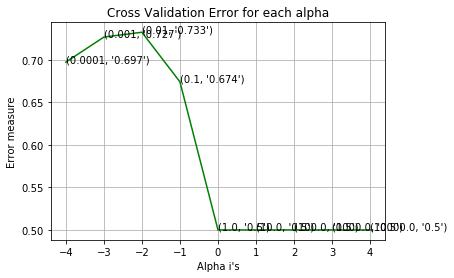

The Optimal C value is: 0.01


In [88]:
## parameter tuning 
alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_final, y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final)[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])

parameter tuning:

In [119]:
# best_alpha = alpha[np.argmax(cv_auc_score)]
best_alpha=0.01
logreg = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', penalty = 'l1', loss='log', random_state = 28)
logreg.fit(X_train_final, y_train)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid')
logreg_sig_clf.fit(X_train_final, y_train)
y_pred_prob = logreg_sig_clf.predict_proba(X_train_final)[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = logreg_sig_clf.predict_proba(X_val_final)[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = logreg_sig_clf.predict_proba(X_test_final)[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob) ))
y_pred = logreg.predict(X_test_final)
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))

For best alpha 0.01, The Train AUC score is 0.7381229752239385
For best alpha 0.01, The Cross validated AUC score is 0.7325469584885868
For best alpha 0.01, The Test AUC score is 0.7231713106274062
The test AUC score is : 0.7231713106274062
The percentage of misclassified points 31.92% :


In [90]:
import statsmodels.discrete.discrete_model as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *

In [91]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        df = x.drop(col, axis=1)

    return df

## **Part 3: Model Evaluation [25 Marks]**

* 3.1 Confusion matrix [5 Marks] 

Calculate the confusion matrix using the testing set. 

In [98]:
### YOUR CODE HERE ###
#Look into the function and corresponding parameters; confusion_matrix
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()


In [93]:
# Mark it as a 1 if logit prediction for up is above 50%, and 0 otherwise
predict_label_smf = pd.DataFrame(np.zeros(shape=(4348,1)), columns = ['label'])
predict_label_smf.iloc[logitsmf.predict(x_test_final)>0.5] = 1


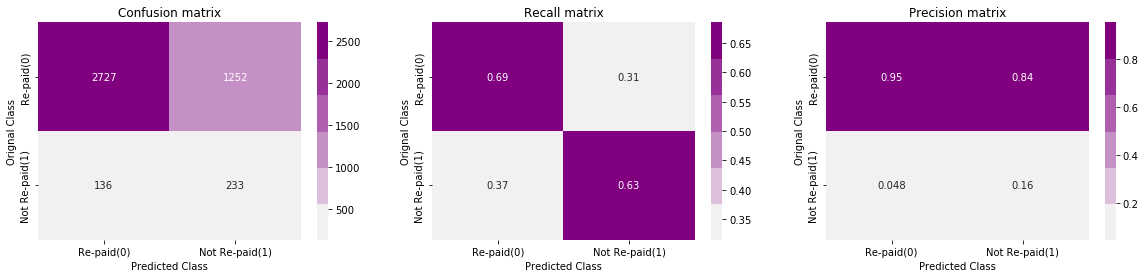

In [123]:
plot_confusion_matrix(y_test, y_pred)

* 3.2 Explaining the confusion matrix [5 Marks]

Explain a weakness or a strength of the model based on the confusion matrix. 


 MY EXPLAINATION HERE:
 
target variable is defined as: Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Firstly, the data set is very unbalanced, 90% of target data are 0, so we could see that False Negative and False positive are higher than True positive and True negative.

Secondly, False Positive: (Type 1 Error) Interpretation: You predicted positive and it’s false, this means that the model trust the customer too much even the customer cannot repay the loan but the model will output the customer can pay the load; False Negative: (Type 2 Error) Interpretation: You predicted negative and it’s false. You predicted that a customer is not able to pay but she actually is able to do that.

From our model's result, we find that type 1 error of this model is higher than type 2 error which means that our model is more likely to trust a customer. 


* 3.3 Graphic illustration of the performance [5 Marks]

Plot the ROC curve (receiver operating characteristic curve) showing the performance of the model.
Calculate AUC (Area under the curve) respectively

In [4]:
y_test=[1,1,1,0,1,0,0,1,0,0]
y_pred_prob=[0.880797078,0.999999998,1,2.06115E-09,4.24835E-18,0.999954602,0.999999998,1,4.53979E-05,2.06115E-09]

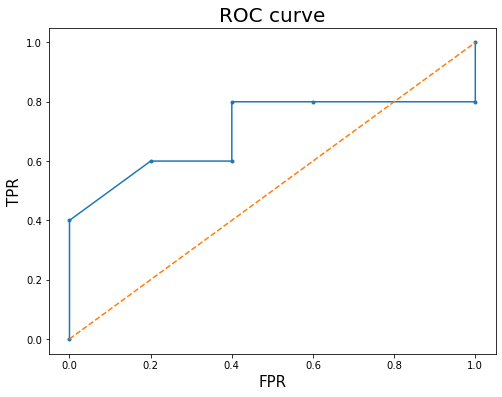

In [10]:
### YOUR CODE HERE ###
y_test=[1,1,1,0,1,0,0,1,0,0]
y_pred_prob=[0.880797078,0.999999998,1,2.06115E-09,4.24835E-18,0.999954602,0.999999998,1,4.53979E-05,2.06115E-09]
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,pos_label=1)
# auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
# plt.grid()
# plt.legend(["AUC=%.3f"%auc])
plt.show()

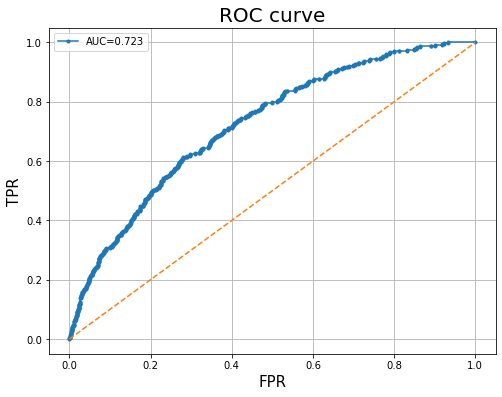

In [97]:
### YOUR CODE HERE ###
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. We can see the model's AUV is 0.723, which means that the model has learned better than random predictor

* 3.4 Compute the performance measures [5 Marks]

Compute the following measures to assess the performance of the logistic regression model: 
    precision, recall, F_1-score, accuracy, and total misclassification rate; 
    using the testing set.

In [124]:
### YOUR CODE HERE ###
#Given the confusion matrix result, note that this can be computed manually using formula as well
from sklearn.metrics import classification_report

# y_pred = logreg.predict(X_test_final)
lr_y_pred = logreg.predict(X_test_final)
print(classification_report(y_test, lr_y_pred))
print('The total misclassification rate {:05.2f}% :'.format((1-accuracy_score(y_test, lr_y_pred))*100))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80      3979
           1       0.16      0.63      0.25       369

    accuracy                           0.68      4348
   macro avg       0.55      0.66      0.52      4348
weighted avg       0.88      0.68      0.75      4348

The total misclassification rate 31.92% :


* 3.5 Suitable performance measures for reporting [5 Marks]

If you were to only choose two of the five performance measures for reporting, which ones do you choose? 
Justify your choice.

In [100]:
### YOUR EXPLAINATION HERE ###


F1 Score should be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).so i will chose F1 score;

Classification accuracy is the most-used metric for evaluating classification models. However, when Accuracy Fails for Imbalanced Classification, so i will not choose accuracy because accuracy can become an unreliable measure of model performance. For total miss classification rate it's (1- accuracy ) so it 's also not very realiable

precision is defined as: TP/(TP+FP) ; recall is defined as TP/(TP+FN). They both could indicate model's performance on this unbalanced data set. So i will choose either one of them., i.e, precision or recall

if we focus on control FP, then we choose precision; if we focus on control FN, we prefer to choose recall.

## **Part 4: Alternative classification model [20 marks]**
Select an alternative classification model that has at least one tunable hyper-parameter.

**HINT !**

You might want to try random forest or boosted tree etc.

* 4.1 Train the alternative classification model [5 marks]

Train your alternative model on the same training set.

* 4.2 Tune the alternative classification model [5 Marks]

Use a k-fold cross validation to tune the hyper-parameters of the alternative model based on accuracy. 

* 4.3 Confusion matrix [5 Marks]

Calculate the confusion matrix using the testing set.

#### random forest

We constructed the random forest classifer and tune the n_estimator and max_depth using a k fold cross validation

In [95]:
alpha = [200,500,1000,2000]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final, y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final)[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))


For n_estimators 200, max_depth 7 cross validation AUC score 0.7120111563971722
For n_estimators 200, max_depth 10 cross validation AUC score 0.7064391042101467
For n_estimators 500, max_depth 7 cross validation AUC score 0.7119107652130204
For n_estimators 500, max_depth 10 cross validation AUC score 0.7067901318880645
For n_estimators 1000, max_depth 7 cross validation AUC score 0.7113493941016423
For n_estimators 1000, max_depth 10 cross validation AUC score 0.7066487647103817
For n_estimators 2000, max_depth 7 cross validation AUC score 0.711550859403171
For n_estimators 2000, max_depth 10 cross validation AUC score 0.7072292579520745


In [96]:
alpha = [200,500,1000,2000]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final, y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final)[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))


For n_estimators 200, max_depth 7 cross validation AUC score 0.7120111563971722
For n_estimators 200, max_depth 10 cross validation AUC score 0.7064391042101467
For n_estimators 500, max_depth 7 cross validation AUC score 0.7119107652130204
For n_estimators 500, max_depth 10 cross validation AUC score 0.7067901318880645
For n_estimators 1000, max_depth 7 cross validation AUC score 0.7113493941016423
For n_estimators 1000, max_depth 10 cross validation AUC score 0.7066487647103817
For n_estimators 2000, max_depth 7 cross validation AUC score 0.711550859403171
For n_estimators 2000, max_depth 10 cross validation AUC score 0.7072292579520745


The optimal values are: n_estimators 200, max_depth 7 
For best n_estimators 200 best max_depth 7, The Train AUC score is 0.8398387088279861
For best n_estimators 200 best max_depth 7, The Validation AUC score is 0.7120111563971722
For best n_estimators 200 best max_depth 7, The Test AUC score is 0.7093977800798366
The test AUC score is : 0.7093977800798366
The percentage of misclassified points 08.49% :


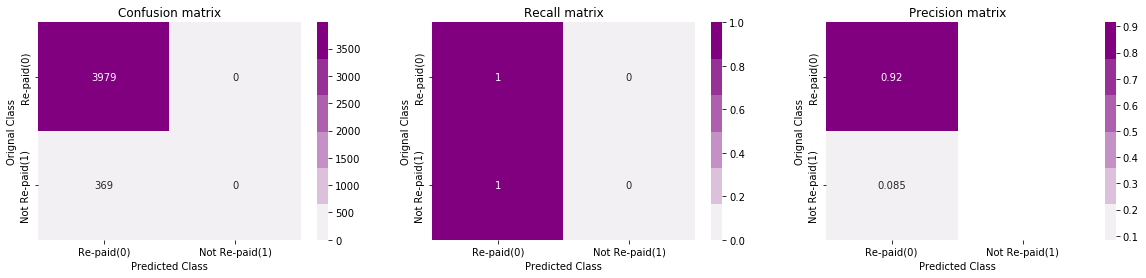

In [99]:
best_alpha = np.argmax(cv_auc_score)
print('The optimal values are: n_estimators {0}, max_depth {1} '.format(alpha[int(best_alpha/2)],
                                                                        max_depth[int(best_alpha%2)]))
rf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_final, y_train)
rf_sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
rf_sig_clf.fit(X_train_final, y_train)
y_pred_prob = rf_sig_clf.predict_proba(X_train_final)[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(alpha[int(best_alpha/2)], 
                                                    max_depth[int(best_alpha%2)],roc_auc_score(y_train,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_val_final)[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                            max_depth[int(best_alpha%2)],roc_auc_score(y_val,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_test_final)[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                        max_depth[int(best_alpha%2)],roc_auc_score(y_test,y_pred_prob)))
y_pred = rf_sig_clf.predict(X_test_final)
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

* 4.4 Graphic illustration of the performance [5 Marks]

Plot the ROC curve (receiver operating characteristic curve) showing the performance of the model.
Calculate AUC (Area under the curve) respectively

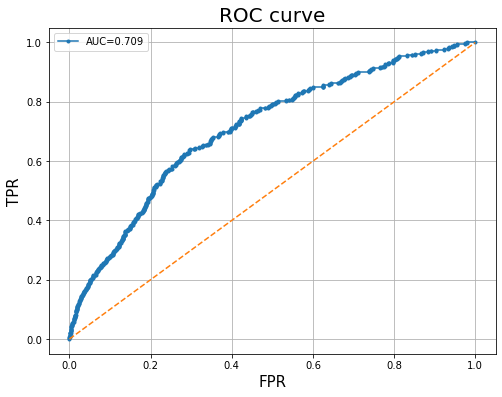

In [100]:
### YOUR CODE HERE ###
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()


In [101]:
### YOUR CODE HERE ###
#Given the confusion matrix result, note that this can be computed manually using formula as well
from sklearn.metrics import classification_report


y_pred = rf_sig_clf.predict(X_test_final)
print(classification_report(y_test, y_pred))
print('The total misclassification rate {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3979
           1       0.00      0.00      0.00       369

    accuracy                           0.92      4348
   macro avg       0.46      0.50      0.48      4348
weighted avg       0.84      0.92      0.87      4348

The total misclassification rate 08.49% :


## **Part 5: Compare the two models [15 Marks]**

Use the test data to compare the logistic regression model and the tuned alternative model.

* 5.1 Compare predictive performance [5 Marks]

Choose a suitable plot and illustrate all the five performance measures (precision, recall, F_1-score, accuracy, and total misclassification rate) for the two models. 
Use appropriate figure size, title/caption, legend, and axis titles.

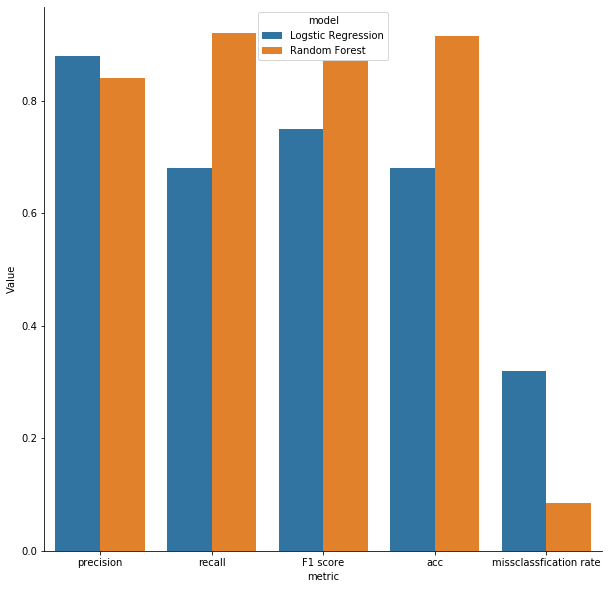

In [11]:
### YOUR CODE HERE ###

# LR: precision, 0.88  recall, 0.68 F_1-score, 0.75  accuracy 68.08 , and total misclassification rate 31.92 
# RF: precision, 0.84, recall, 0.92, F_1-score, 0.87 accuracy, 91.51 and total misclassification rate 8.49
#bar plot
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame({
    'Factor': ['precision', 'recall','F1 score','acc','missclassfication rate'],
    'Logstic Regression': [0.88, 0.68,0.75,0.6808,0.3192],
    'Random Forest': [0.84, 0.92,0.87,0.9151,0.0849]
})
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df.melt(id_vars='Factor').rename(columns=str.title)
seaborn.barplot(x='Factor', y='Value', hue='Variable', data=tidy, ax=ax1)
ax1.set(xlabel='metric')
plt.legend(title='model')
seaborn.despine(fig)

* 5.2 Recommend model to client (scenario 1) [5 Marks]

Among the two models you have developed, what is you suggested model to Home Credit Group (client of the project), 
if they are more concerned about rejecting applications of individuals who may otherwise end up having difficulty in repayment? 
 Provide a numeric measure for each of the two models to justify your response.


In [ ]:
### YOUR EXPLAINATION HERE ###

definition of precision : TP/(TP+FP)


definition of recall : TP/(TP+FN)


1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases

'if they are more concerned about rejecting applications of individuals who may otherwise end up having difficulty in repayment? ' means the  false positives are less important than false negatives So, we want to control FN. Based on this definition, we want to control FN. So we would prefer the model with higher recall. 


From the result above, we see that random forest model has higher recall than logistic regression, so we would recommend the random forest model

* 5.3 Recommend model to client (scenario 2) [5 Marks]

Among the two models you have developed, what is you suggested model to Home Credit Group (client of the project), 
if they are more concerned about not rejecting applications of individuals who may be capable of repayment according to the data? 
 Provide a numeric measure for each of the two models to justify your response.

In [ ]:
### YOUR EXPLAINATION HERE ###

'if they are more concerned about not rejecting applications of individuals who may be capable of repayment according to the data? means that false positive means incorrectly incarcerating an innocent person. So, we want to control FP. So we want to choose the model with higher precision.

From the result above, we see that logistic regression model has higher precision than random forest, so we would recommend the logistic regression model

## Reference 

[1] https://www.kaggle.com/c/home-credit-default-risk/data

[2] https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall 

[3] https://www.kaggle.com/ersinztrk/home-credit-clean-code 